## Load data

In [3313]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [3314]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
# algo = "reverse_hybrid"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [3315]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

merged_df.shape

(1062, 30)

In [3316]:
# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

In [3317]:
merged_df = merged_df[~merged_df['communityId'].isna()]
merged_df.shape

(1062, 32)

In [3318]:
merged_df.isna().sum()

patientId                     0
sampleId                      0
CLL_EPITYPE                   0
DISEASE_TYPE                  0
IGLV3_21_R110                26
MUTATION_COUNT               88
TMB_NONSYNONYMOUS            88
TUMOR_MOLECULAR_SUBTYPE     145
U1_STATUS                   199
AGE                          50
AGE_SAMPLING                  0
COHORT                        0
DEATH_DAYS                    0
EXPRESSION_CLUSTER            0
FFS_MONTHS                    0
FFS_STATUS                    0
IGHV_IDENTITY_PERCENTAGE     18
IGHV_MUTATION_STATUS         15
OS_MONTHS                     0
OS_STATUS                     0
PRIOR_TREATMENT_CATEGORY      0
SEX                           0
TREATMENT_AFTER_SAMPLING    613
TREATMENT_STATUS              0
originId                      0
year                          0
originType                    0
originIdentifier              0
nodeId                        0
communityId                   0
FFS_STATUS_EVENT              0
OS_STATU

In [3319]:
merged_df['TUMOR_MOLECULAR_SUBTYPE'] = merged_df['TUMOR_MOLECULAR_SUBTYPE'].fillna('unknown')
merged_df['CLL_EPITYPE'] = merged_df['CLL_EPITYPE'].replace('unclassified', 'unknown')
merged_df['IGHV_MUTATION_STATUS'] = merged_df['IGHV_MUTATION_STATUS'].fillna('unknown')

In [3320]:
mutation_df.isna().sum()    

chr                   0
endPosition           0
entrezGeneId          0
keyword             396
mutationType          0
normalAltCount     1251
normalRefCount     1251
patientId             0
proteinChange         0
proteinPosEnd         0
proteinPosStart       0
referenceAllele       0
startPosition         0
tumorAltCount         0
tumorRefCount         0
variantAllele         0
variantType           0
hugoGeneSymbol        0
type                  0
dtype: int64

## Clinical Analysis

In [3321]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# plot_community_sizes(community_df)

In [3322]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
# print_overlapping_nodes(community_df)

In [3323]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.violinplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

In [3324]:
# demographic_summary(merged_df)

In [3325]:
import plotly.express as px
import plotly.graph_objects as go


def compare_age_mutation_count(merged_df, comm1, comm2):

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([comm1, comm2])], y='AGE_SAMPLING', x='communityId', box=True, points='all',
                        title='Violin Plot of AGE_SAMPLING by Community')
    fig_violin.show()

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([0,1,2,3])], y='MUTATION_COUNT', x='communityId', box=True, points='all',
                        title='Violin Plot of MUTATION_COUNT by Community')
    fig_violin.show()

    # 2. KDE plot for AGE_SAMPLING for communities 1 and 2
    from scipy.stats import gaussian_kde

    # Filter data for communities 1 and 2
    df_1 = merged_df[merged_df['communityId'] == comm1]['AGE_SAMPLING']
    df_2 = merged_df[merged_df['communityId'] == comm2]['AGE_SAMPLING']

    # Generate KDEs
    kde_1 = gaussian_kde(df_1)
    kde_2 = gaussian_kde(df_2)

    x_vals = np.linspace(merged_df['AGE_SAMPLING'].min(), merged_df['AGE_SAMPLING'].max(), 200)
    y_1 = kde_1(x_vals)
    y_2 = kde_2(x_vals)

    # Create KDE plot
    fig_kde = go.Figure()
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_1, mode='lines', name=f'Community {comm1}'))
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_2, mode='lines', name=f'Community {comm2}'))
    fig_kde.update_layout(title=f'KDE Plot of AGE_SAMPLING for Communities {comm1} and {comm2}',
                        xaxis_title='AGE_SAMPLING',
                        yaxis_title='Density')
    fig_kde.show()

In [3326]:
# compare_age_mutation_count(merged_df, 0, 1)

In [3327]:
# compare_age_mutation_count(merged_df, 1, 2)

In [3328]:
# compare_age_mutation_count(merged_df, 2, 3)

In [3329]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated   unknown  unmutated
communityId                                        
0                     0.328671  0.013986   0.657343
1                     0.500000  0.000000   0.500000
2                     0.404834  0.018127   0.577039
3                     0.751979  0.013193   0.234828


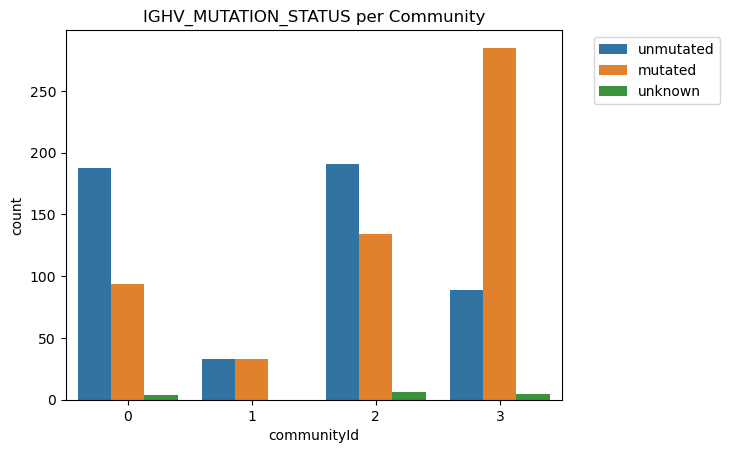


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL   unknown
communityId                                        
0            0.101399  0.223776  0.580420  0.094406
1            0.106061  0.272727  0.287879  0.333333
2            0.154079  0.232628  0.465257  0.148036
3            0.155673  0.525066  0.171504  0.147757


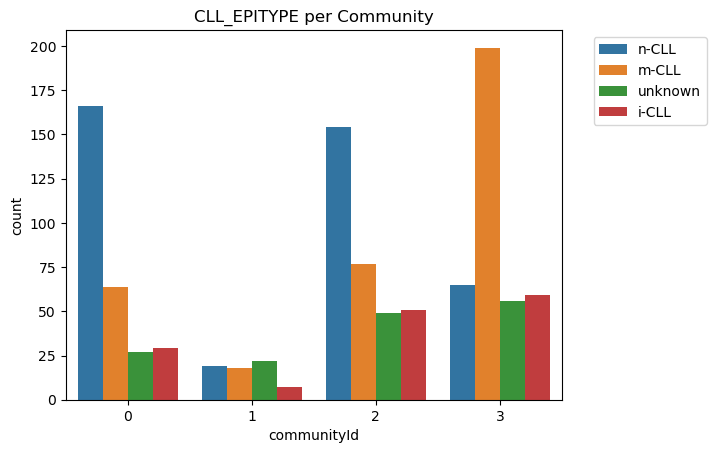


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL   unknown
communityId                                          
0                        0.419580  0.458042  0.122378
1                        0.651515  0.272727  0.075758
2                        0.492447  0.398792  0.108761
3                        0.451187  0.366755  0.182058


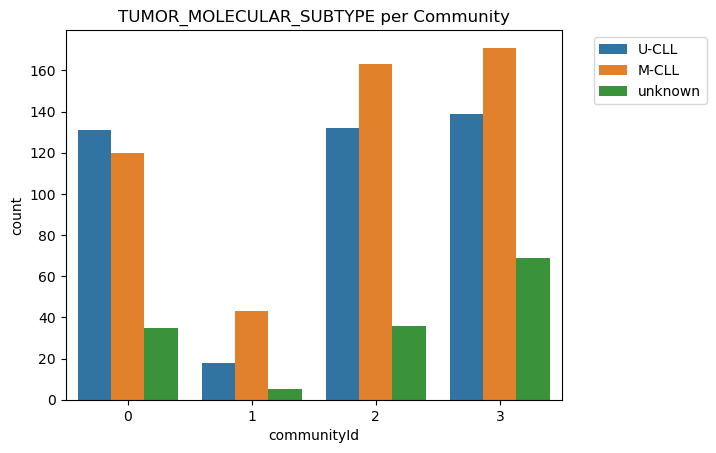


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.003497    0.052448       0.038462  0.000000   
1                              0.000000    0.000000       0.030303  0.000000   
2                              0.003021    0.036254       0.018127  0.003021   
3                              0.002639    0.026385       0.021108  0.000000   

PRIOR_TREATMENT_CATEGORY   Rel/Ref  Untreated  
communityId                                    
0                         0.020979   0.884615  
1                         0.000000   0.969697  
2                         0.036254   0.903323  
3                         0.010554   0.939314  


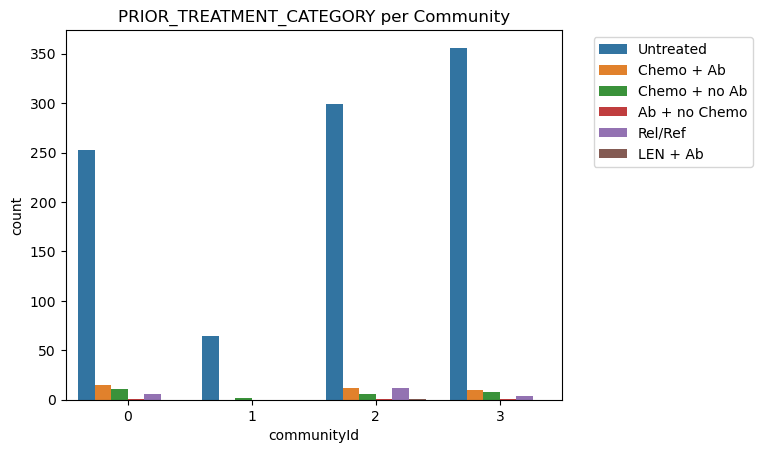


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.067164   0.000000    0.000000      0.007463   
1                              0.030769   0.000000    0.000000      0.000000   
2                              0.043011   0.005376    0.005376      0.005376   
3                              0.062500   0.000000    0.000000      0.031250   

TREATMENT_AFTER_SAMPLING  BCL2 inhibitor  BTK + chemo + Ab  BTK inhibitor  \
communityId                                                                 
0                               0.007463          0.000000       0.007463   
1                               0.000000          0.000000       0.000000   
2                               0.005376          0.010753       0.069892   
3                               0.000000          0.000000       0.062500   


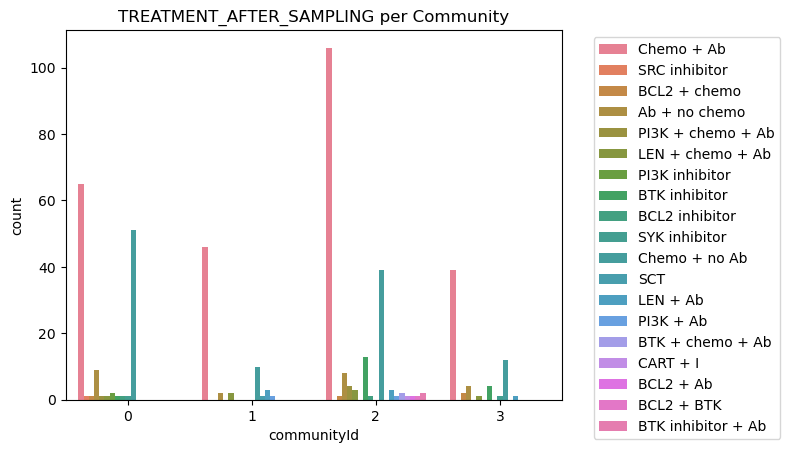

In [3330]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)

In [3331]:
def get_treatment_stats_by_community(df, community_id):
    # Filter the dataframe for the given community
    community_df = df[df['communityId'] == community_id]

    # Total number of patients in the community
    total_patients = len(community_df)

    # Group by TREATMENT_AFTER_SAMPLING and count occurrences including NaN
    treatment_counts = community_df['TREATMENT_AFTER_SAMPLING'].value_counts(dropna=False)

    # Create a list of dictionaries with treatment, count, and percentage
    treatment_stats = []
    for treatment, count in treatment_counts.items():
        treatment_stats.append({
            'TREATMENT_AFTER_SAMPLING': treatment,
            'Count': count,
            'Percentage': round((count / total_patients) * 100, 2) if total_patients > 0 else 0.0
        })

    # Sort the list by percentage of patients in descending order
    treatment_stats_sorted = sorted(treatment_stats, key=lambda x: x['Percentage'], reverse=True)

    return treatment_stats_sorted

In [3332]:
treatment_data = {}
for i in range(4):
    treatment_data[i] = get_treatment_stats_by_community(merged_df, i)
display(treatment_data)

{0: [{'TREATMENT_AFTER_SAMPLING': nan, 'Count': 152, 'Percentage': 53.15},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab', 'Count': 65, 'Percentage': 22.73},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Count': 51,
   'Percentage': 17.83},
  {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
   'Count': 9,
   'Percentage': 3.15},
  {'TREATMENT_AFTER_SAMPLING': 'PI3K inhibitor',
   'Count': 2,
   'Percentage': 0.7},
  {'TREATMENT_AFTER_SAMPLING': 'SRC inhibitor',
   'Count': 1,
   'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo', 'Count': 1, 'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'PI3K + chemo + Ab',
   'Count': 1,
   'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
   'Count': 1,
   'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
   'Count': 1,
   'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 inhibitor',
   'Count': 1,
   'Percentage': 0.35},
  {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
   'Count':

In [3333]:
# Function to compare two communities
def compare_two_communities_for_treatment(data, id1, id2):
    set1 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id1]}
    set2 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common treatments between community {id1} and {id2}:", common)
    print(f"Unique to community {id1}:", unique_to_id1)
    print(f"Unique to community {id2}:", unique_to_id2)
    return common, unique_to_id1, unique_to_id2

In [3334]:
# common_0_1, unique_0, unique_1 = compare_two_communities_for_treatment(treatment_data, 0, 1)

In [3335]:
# common_1_2, unique_1, unique_2 = compare_two_communities_for_treatment(treatment_data, 1, 2)

In [3336]:
# common_2_3, unique_2, unique_3 = compare_two_communities_for_treatment(treatment_data, 2, 3)

In [3337]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER']
# clinical_summary(merged_df, clinical_features)

In [3338]:
clinical_features = ['COHORT','originId', 'originType']
# clinical_summary(merged_df, clinical_features)

In [3339]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())
        
        sns.violinplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()

In [3340]:
clinical_numeric_features = ['MUTATION_COUNT']#  'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
# clinical_numeric_summary(merged_df, clinical_numeric_features)

## Mutations

In [3341]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [3342]:
mutation_annotated.shape

(29526, 22)

In [3343]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

In [3344]:
# mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [3345]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()


In [3346]:
small_categorical_features = ['mutationType', 'variantType']
# plot_small_categoricals(mutation_annotated, small_categorical_features)

In [3347]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    top_mutations = {}
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        top_mutations[cid] = []
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
            top_mutations[cid].append({col: val, 'Percentage': round(pct, 2)})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))

    return top_mutations
    
    # # Plot: Stacked bar, only top N per community, percentage of patients
    # plot_df = pd.DataFrame(plot_data)
    # pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    # ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    # plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    # plt.ylabel("% of Patients in Community")
    # plt.xlabel("Community")
    # plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    
    # # Annotate percentages on bars
    # for i, (idx, row) in enumerate(pivot.iterrows()):
    #     cumm = 0
    #     for j, val in enumerate(row):
    #         if val > 0:
    #             plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
    #             cumm += val
    # plt.show()

In [3348]:
top_mutations = top_values_by_community(mutation_annotated, 'hugoGeneSymbol', top_n=10)
top_mutations


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,AHNAK,ATM,BRAF,CHD2,CSMD1,CSMD3,EGR2,FAT1,KLHL6,KRAS,...,NOTCH1,PCLO,POT1,SF3B1,TP53,TTN,USH2A,XPO1,ZFHX4,ZMYM3
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,13.67,6.25,0.00,0.00,0.00,5.86,0.00,0.00,0.00,...,8.98,8.20,5.86,24.61,15.62,8.98,0.00,8.98,0.00,0.00
1,7.94,0.00,0.00,0.00,7.94,7.94,0.00,7.94,0.00,7.94,...,0.00,0.00,0.00,22.22,0.00,9.52,7.94,0.00,0.00,7.94
2,0.00,14.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.13,...,5.13,0.00,9.29,24.36,10.90,5.45,0.00,6.09,5.13,0.00
3,0.00,7.85,0.00,6.69,0.00,5.81,0.00,0.00,5.52,0.00,...,0.00,5.81,0.00,8.72,0.00,7.85,0.00,0.00,0.00,0.00


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(24.61)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(15.62)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(13.67)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(8.98)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(8.2)},
  {'hugoGeneSymbol': 'BRAF', 'Percentage': np.float64(6.25)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(5.86)},
  {'hugoGeneSymbol': 'EGR2', 'Percentage': np.float64(5.86)}],
 1: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(22.22)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(9.52)},
  {'hugoGeneSymbol': 'ZMYM3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'CSMD1', 'Percentage': np.float64(7.94)},
  {'hugoGeneSymbol': 'USH2A', 'Percentage': np.float64(7

In [3349]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from upsetplot import UpSet


# Function to compare two communities
def compare_two_communities(data, id1, id2):
    set1 = {gene['hugoGeneSymbol'] for gene in data[id1]}
    set2 = {gene['hugoGeneSymbol'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common mutations between community {id1} and {id2}:", common)
    print(f"Unique to community {id1}:", unique_to_id1)
    print(f"Unique to community {id2}:", unique_to_id2)
    return common, unique_to_id1, unique_to_id2

# Function to compare all four communities
def compare_all_communities(data):
    sets = [set(gene['hugoGeneSymbol'] for gene in data[i]) for i in range(4)]
    common_all = set.intersection(*sets)
    unique_all = [s - set.union(*(sets[:i] + sets[i+1:])) for i, s in enumerate(sets)]
    return common_all, unique_all

In [3350]:
# common_0_1, unique_0, unique_1 = compare_two_communities(top_mutations, 0, 1)

In [3351]:
# common_1_2, unique_1, unique_2 = compare_two_communities(top_mutations, 1, 2)

In [3352]:
# common_2_3, unique_2, unique_3 = compare_two_communities(top_mutations, 2, 3)

In [3353]:
# common_all, unique_all = compare_all_communities(top_mutations)
# print("Common mutations in all communities:", common_all)
# print("Unique mutations in each community:", unique_all)

{0: ['SF3B1',
  'TP53',
  'ATM',
  'NOTCH1',
  'TTN',
  'XPO1',
  'PCLO',
  'BRAF',
  'POT1',
  'EGR2'],
 1: ['SF3B1',
  'TTN',
  'ZMYM3',
  'CSMD3',
  'CSMD1',
  'USH2A',
  'FAT1',
  'AHNAK',
  'KRAS',
  'MYD88'],
 2: ['SF3B1',
  'ATM',
  'TP53',
  'POT1',
  'XPO1',
  'LRP1B',
  'TTN',
  'ZFHX4',
  'KRAS',
  'NOTCH1'],
 3: ['SF3B1',
  'TTN',
  'ATM',
  'CHD2',
  'PCLO',
  'CSMD3',
  'MUC16',
  'KLHL6',
  'MYD88',
  'LRP1B']}

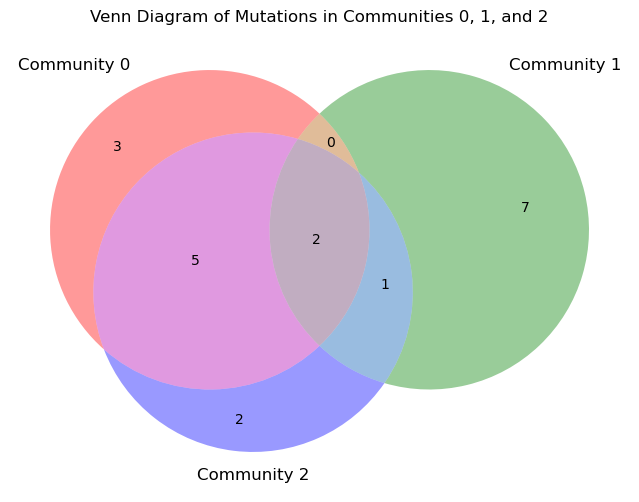

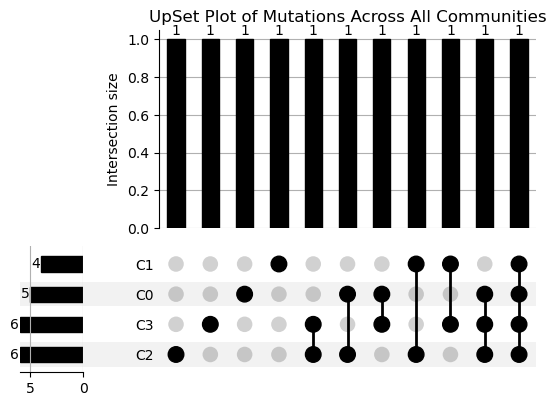

In [3354]:
mutation_data = {}
for i in range(4):
    mutation_data[i] = [i['hugoGeneSymbol'] for i in top_mutations[i]]

display(mutation_data)

# Create sets for communities 0, 1, 2
set0 = set(mutation_data[0])
set1 = set(mutation_data[1])
set2 = set(mutation_data[2])

# Plot Venn diagram for communities 0, 1, 2
plt.figure(figsize=(8, 6))
venn3([set0, set1, set2], set_labels=('Community 0', 'Community 1', 'Community 2'))
plt.title("Venn Diagram of Mutations in Communities 0, 1, and 2")
plt.show()

# Prepare data for UpSet plot for all four communities
all_genes = set.union(*[set(mutation_data[i]) for i in range(4)])
data = []

for gene in all_genes:
    presence = tuple(gene in mutation_data[i] for i in range(4))
    data.append(presence)

# Create a DataFrame for UpSet plot
df = pd.DataFrame(data, columns=['C0', 'C1', 'C2', 'C3'])
df['count'] = 1
df = df.groupby(['C0', 'C1', 'C2', 'C3']).count()

# Plot UpSet plot
upset = UpSet(df, subset_size='count', show_counts=True)
upset.plot()
plt.title("UpSet Plot of Mutations Across All Communities")
plt.show()


In [3355]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
# for col in columns_to_analyze:
#     top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [3356]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()

In [3357]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
# numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

## Community 3 dissection

In [3358]:
community_3 = merged_df[merged_df['communityId'] == 3]
mutation_3 = mutation_annotated[mutation_annotated['communityId'] == 3]
community_3.shape

(379, 32)

In [3359]:
failed_community_3 = community_3[community_3['FFS_STATUS_EVENT'] == 1]
failure_free_community_3 =  community_3[community_3['FFS_STATUS_EVENT'] == 0]
failed_community_3.shape

(7, 32)

In [3360]:
failed_community_3['FFS_MONTHS']

23     146.04
25     128.38
97     137.46
603    134.17
708    141.70
803    119.18
851    163.46
Name: FFS_MONTHS, dtype: float64

In [3361]:
# 1. Violin plot of AGE_SAMPLING grouped by community
fig_violin = px.violin(community_3, y='AGE_SAMPLING', x='FFS_STATUS_EVENT', box=True, points='all',
                    title='Violin Plot of AGE_SAMPLING by FFS_STATUS_EVENT')
fig_violin.show()

# 1. Violin plot of AGE_SAMPLING grouped by community
fig_violin = px.violin(community_3, y='MUTATION_COUNT', x='FFS_STATUS_EVENT', box=True, points='all',
                    title='Violin Plot of MUTATION_COUNT by FFS_STATUS_EVENT')
fig_violin.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated   unknown  unmutated
FFS_STATUS_EVENT                                   
0                     0.750000  0.013441   0.236559
1                     0.857143  0.000000   0.142857


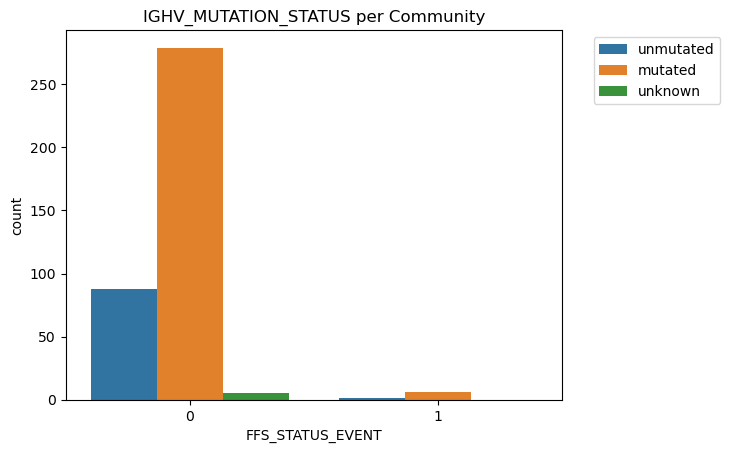


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE          i-CLL     m-CLL     n-CLL   unknown
FFS_STATUS_EVENT                                        
0                 0.155914  0.521505  0.174731  0.147849
1                 0.142857  0.714286  0.000000  0.142857


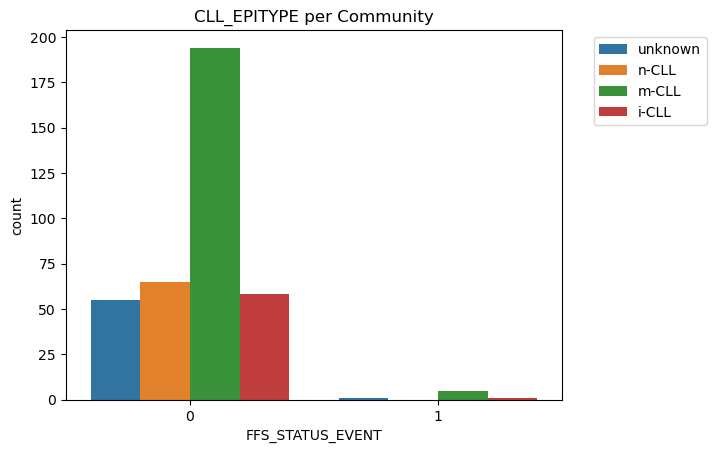


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL   unknown
FFS_STATUS_EVENT                                     
0                        0.443548  0.370968  0.185484
1                        0.857143  0.142857  0.000000


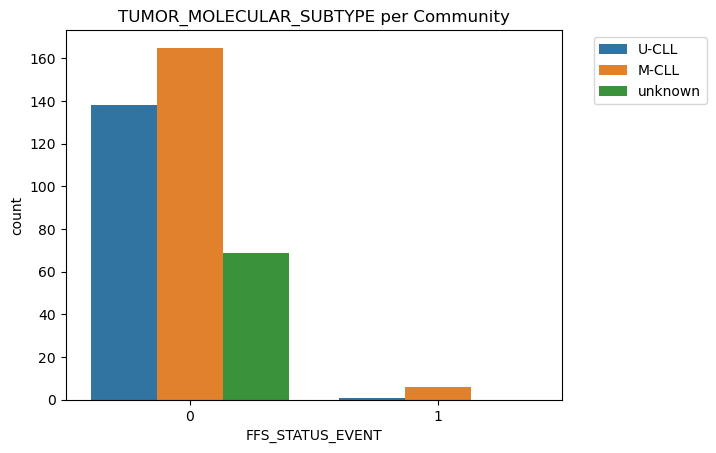


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + chemo  BTK inhibitor  \
FFS_STATUS_EVENT                                                       
0                              0.070175      0.035088       0.035088   
1                              0.000000      0.000000       0.285714   

TREATMENT_AFTER_SAMPLING  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
FFS_STATUS_EVENT                                                
0                           0.631579       0.192982  0.017544   
1                           0.428571       0.142857  0.000000   

TREATMENT_AFTER_SAMPLING  LEN + chemo + Ab  SYK inhibitor  
FFS_STATUS_EVENT                                           
0                                 0.000000       0.017544  
1                                 0.142857       0.000000  


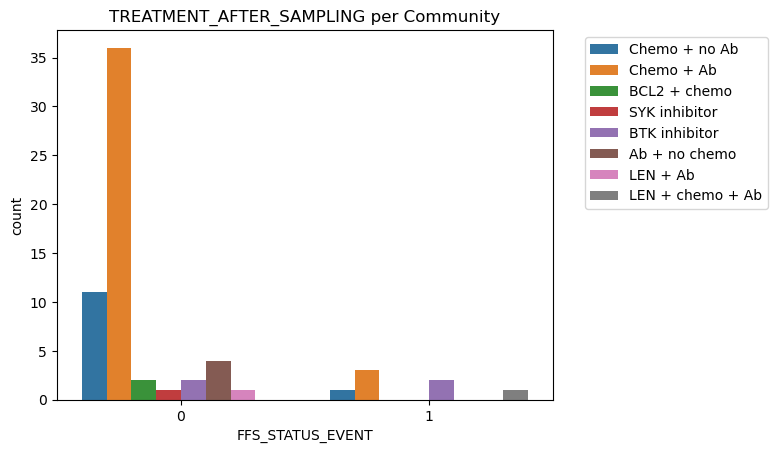

In [3362]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(community_3, clinical_features, 'FFS_STATUS_EVENT')

In [3363]:
import pandas as pd

# Assuming community_3 and mutations_3 DataFrames are already defined
# Merge the two DataFrames on 'patientId'
merged_mutation_3 = pd.merge(mutation_3, community_3[['patientId', 'FFS_STATUS_EVENT']], on='patientId')

mutations_data_3 = top_values_by_community(merged_mutation_3, 'hugoGeneSymbol', 'FFS_STATUS_EVENT', 10)
mutations_data_3


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,ATM,CHD2,CSMD3,FAT4,KLHL6,LRP1B,MUC16,MYD88,PCLO,RALYL,RBP3,RFC3,RGMA,RHCG,RPL26L1,SF3B1,SLC22A15,TTN,VWF
Community,,,,,,,,,,,,,,,,,,,
0,7.69,6.8,5.92,0.00,5.62,4.44,5.62,5.33,5.33,0.00,0.00,0.00,0.00,0.00,0.00,8.58,0.00,7.99,0.00
1,0.00,0.0,0.00,33.33,0.00,0.00,0.00,0.00,33.33,16.67,16.67,16.67,16.67,16.67,16.67,0.00,33.33,0.00,33.33


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(8.58)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(7.99)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(7.69)},
  {'hugoGeneSymbol': 'CHD2', 'Percentage': np.float64(6.8)},
  {'hugoGeneSymbol': 'CSMD3', 'Percentage': np.float64(5.92)},
  {'hugoGeneSymbol': 'MUC16', 'Percentage': np.float64(5.62)},
  {'hugoGeneSymbol': 'KLHL6', 'Percentage': np.float64(5.62)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(5.33)},
  {'hugoGeneSymbol': 'MYD88', 'Percentage': np.float64(5.33)},
  {'hugoGeneSymbol': 'LRP1B', 'Percentage': np.float64(4.44)}],
 1: [{'hugoGeneSymbol': 'FAT4', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'SLC22A15', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'VWF', 'Percentage': np.float64(33.33)},
  {'hugoGeneSymbol': 'RALYL', 'Percentage': np.float64(16.67)},
  {'hugoGeneSymbol': 'RPL26L1', 'Percentage': np.fl

In [3364]:
common_0_1, unique_0, unique_1 = compare_two_communities(mutations_data_3, 0, 1)
print("Common mutations between community 3: ffs-0 and ffs-1:", common_0_1)
print("Unique to community 3 ffs-0:", unique_0)
print("Unique to community 3 ffs-1:", unique_1)

Common mutations between community 0 and 1: {'PCLO'}
Unique to community 0: {'MYD88', 'KLHL6', 'MUC16', 'ATM', 'CHD2', 'LRP1B', 'TTN', 'SF3B1', 'CSMD3'}
Unique to community 1: {'RHCG', 'FAT4', 'VWF', 'RGMA', 'RALYL', 'RPL26L1', 'SLC22A15', 'RFC3', 'RBP3'}
Common mutations between community 3: ffs-0 and ffs-1: {'PCLO'}
Unique to community 3 ffs-0: {'MYD88', 'KLHL6', 'MUC16', 'ATM', 'CHD2', 'LRP1B', 'TTN', 'SF3B1', 'CSMD3'}
Unique to community 3 ffs-1: {'RHCG', 'FAT4', 'VWF', 'RGMA', 'RALYL', 'RPL26L1', 'SLC22A15', 'RFC3', 'RBP3'}


In [3365]:
treatments_data_3 = top_values_by_community(community_3, 'TREATMENT_AFTER_SAMPLING', 'FFS_STATUS_EVENT', 10)
treatments_data_3


🔎 Top 10 values of 'TREATMENT_AFTER_SAMPLING' per community (percentage of patients with at least one TREATMENT_AFTER_SAMPLING):


TREATMENT_AFTER_SAMPLING,Ab + no chemo,BCL2 + chemo,BTK inhibitor,Chemo + Ab,Chemo + no Ab,LEN + Ab,LEN + chemo + Ab,SYK inhibitor
Community,,,,,,,,
0,1.08,0.54,0.54,9.68,2.96,0.27,0.00,0.27
1,0.00,0.00,28.57,42.86,14.29,0.00,14.29,0.00


{0: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   'Percentage': np.float64(9.68)},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Percentage': np.float64(2.96)},
  {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
   'Percentage': np.float64(1.08)},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo', 'Percentage': np.float64(0.54)},
  {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
   'Percentage': np.float64(0.54)},
  {'TREATMENT_AFTER_SAMPLING': 'LEN + Ab', 'Percentage': np.float64(0.27)},
  {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
   'Percentage': np.float64(0.27)}],
 1: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   'Percentage': np.float64(42.86)},
  {'TREATMENT_AFTER_SAMPLING': 'BTK inhibitor',
   'Percentage': np.float64(28.57)},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   'Percentage': np.float64(14.29)},
  {'TREATMENT_AFTER_SAMPLING': 'LEN + chemo + Ab',
   'Percentage': np.float64(14.29)}]}

In [3366]:
common_0_1, unique_0, unique_1 = compare_two_communities_for_treatment(treatments_data_3, 0, 1)
print("Common treatments between community 3: ffs-0 and ffs-1:", common_0_1)
print("Unique to community 3 ffs-0:", unique_0)
print("Unique to community 3 ffs-1:", unique_1)

Common treatments between community 0 and 1: {'Chemo + Ab', 'BTK inhibitor', 'Chemo + no Ab'}
Unique to community 0: {'LEN + Ab', 'SYK inhibitor', 'Ab + no chemo', 'BCL2 + chemo'}
Unique to community 1: {'LEN + chemo + Ab'}
Common treatments between community 3: ffs-0 and ffs-1: {'Chemo + Ab', 'BTK inhibitor', 'Chemo + no Ab'}
Unique to community 3 ffs-0: {'LEN + Ab', 'SYK inhibitor', 'Ab + no chemo', 'BCL2 + chemo'}
Unique to community 3 ffs-1: {'LEN + chemo + Ab'}


## Survival analysis

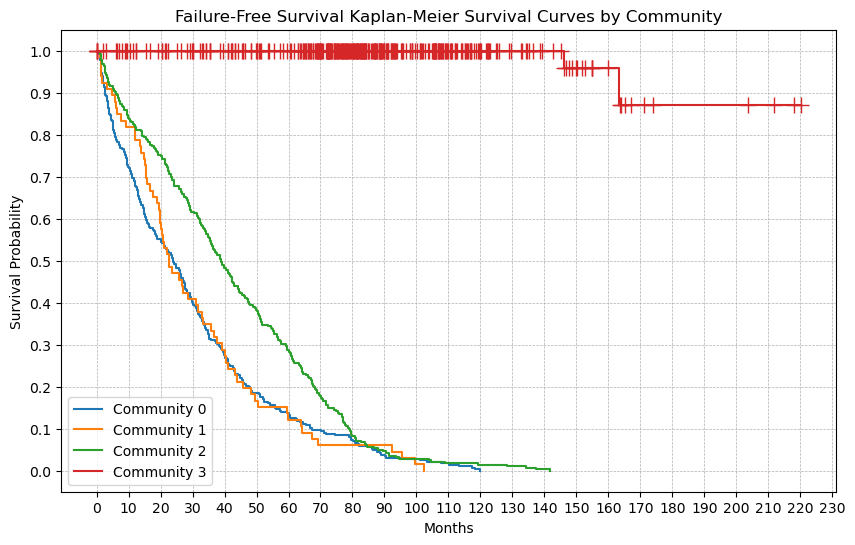

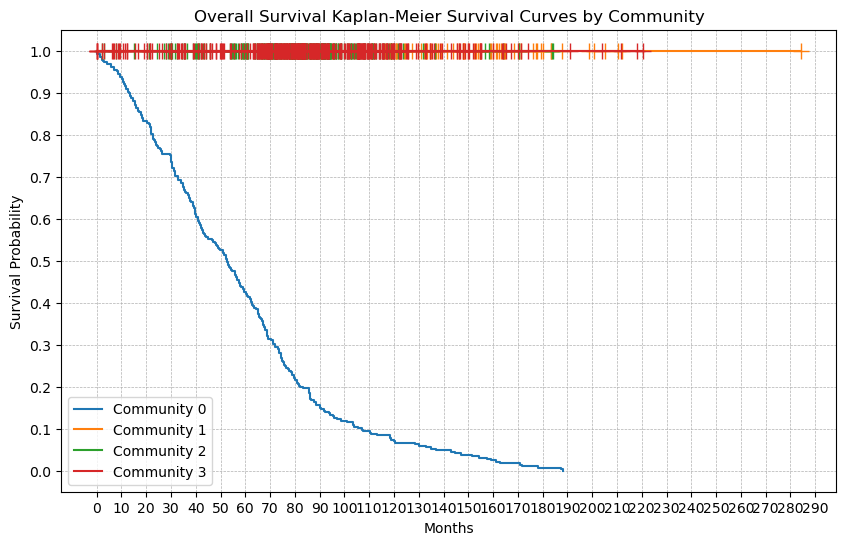

In [3367]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')

    plt.figure(figsize=(10,6))
    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False, show_censors=True)
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    
    # Set ticks at every 10 units
    max_time = df[time_col].max()
    plt.xticks(np.arange(0, max_time + 10, 10))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if time_col == 'FFS_MONTHS':
        plt.savefig("../../figures/survival_curves.png", dpi = 300)
    else:
        plt.savefig("../../figures/os_survival_curves.png", dpi = 300)
    plt.show()

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

In [3368]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

def survival_km_with_stats(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')
    print(df['communityId'].value_counts())

    median_survival_times = {}
    df_median_times = {}
    df_mean_times = {}

    # Define time points for restricted mean survival time
    time_points = [float('inf'), 3, 5, 10]
    mean_survival_times_by_t = {f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)': {} for t in time_points}

    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col])

        # Median survival time from Kaplan-Meier curve
        median_survival_times[name] = kmf.median_survival_time_

        # Mean survival time using area under the curve at different time points
        for t in time_points:
            label_t = f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)'
            new_t = t if t == float('inf') else t*12
            mean_survival_times_by_t[label_t][name] = restricted_mean_survival_time(kmf, t=new_t)

        # Median and mean directly from the DataFrame
        df_median_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].median()
        df_mean_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].mean()

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'KM Median Survival Time': median_survival_times,
        'DF Median Survival Time': df_median_times,
        'DF Mean Survival Time': df_mean_times
    })

    # Add mean survival times at different t values
    for label, values in mean_survival_times_by_t.items():
        summary_df[label] = pd.Series(values)

    return summary_df



summary_ffs = survival_km_with_stats(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
summary_os = survival_km_with_stats(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

print("FFS")
display(summary_ffs)
print("OS")
display(summary_os)


communityId
3    374
0    286
2    282
1     66
Name: count, dtype: int64
communityId
3    374
0    286
2    282
1     66
Name: count, dtype: int64
FFS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,23.74,23.77,29.773951,29.773951,21.619580,26.616084,29.773951
1,22.75,22.67,30.698636,30.698636,23.154697,28.056667,30.698636
2,38.83,38.86,42.360887,42.360887,27.455957,37.108972,42.142057
3,inf,154.75,154.750000,inf,36.000000,60.000000,120.000000


OS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,52.7,52.7,57.191818,57.191818,30.450385,43.389266,54.877098
1,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
2,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
3,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


In [3369]:
# Filter rows where FFS_EVENT is 1
filtered_df = merged_df[merged_df['FFS_STATUS_EVENT'] == 1]

# Find the row with the minimum FFS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['FFS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

# Find the row with the maximum FFS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['FFS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

     communityId  FFS_MONTHS
771            0        0.07
775            1        1.02
776            2        1.02
803            3      119.18
     communityId  FFS_MONTHS
682            0      119.74
29             1      102.25
707            2      141.70
934            3      220.30


In [3370]:
# Filter rows where OS_EVENT is 1
filtered_df = merged_df[merged_df['OS_STATUS_EVENT'] == 1]

# Find the row with the minimum OS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['OS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

# Find the row with the maximum OS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['OS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

     communityId  OS_MONTHS
771            0       0.07
     communityId  OS_MONTHS
654            0     188.15
29             1     284.31
656            2     200.84
934            3     220.30


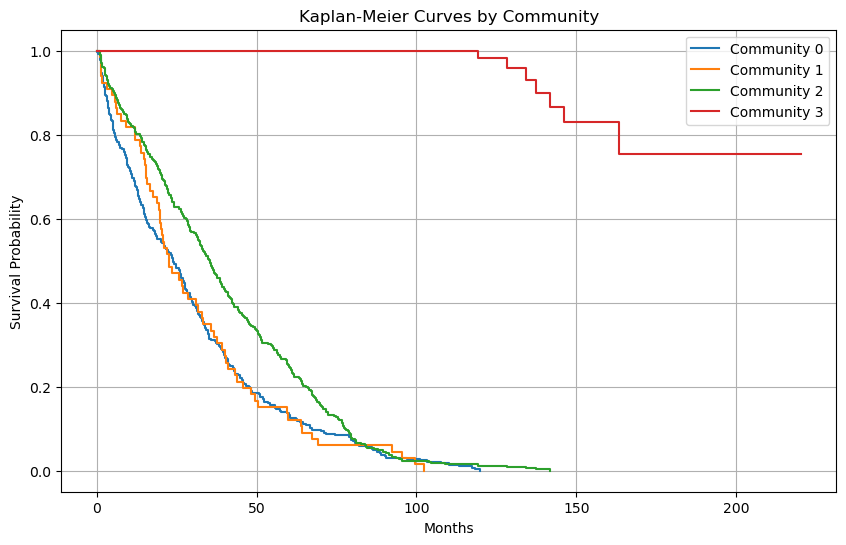

Log-Rank Test between Community 0 and 1: p = 0.9340571712263461
Log-Rank Test between Community 0 and 2: p = 0.0001218061235541513
Log-Rank Test between Community 0 and 3: p = 5.805436285676167e-180
Log-Rank Test between Community 1 and 2: p = 0.019294328058136707
Log-Rank Test between Community 1 and 3: p = 1.6423035939819026e-159
Log-Rank Test between Community 2 and 3: p = 6.892415583295533e-174


<lifelines.CoxPHFitter: fitted with 1062 total observations, 372 right-censored observations>
             duration col = 'FFS_MONTHS'
                event col = 'FFS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 690
   partial log-likelihood = -3811.83
         time fit was run = 2025-07-25 12:12:56 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
communityId_1 -0.01      0.99      0.14           -0.28            0.26                0.76                1.30
communityId_2 -0.32      0.72      0.08           -0.48           -0.16                0.62                0.85
communityId_3 -5.70      0.00      0.46           -6.59           -4.80                0.00                0.01

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00  -0.06   0.96      0.07
communityId_2    0.00  -3.98 <0.005     13.82
communityId_3    0.00 -12.50 <0.005    116.73
---
Concordance = 0.77
Partial AIC = 7629.65
log-likelihood ratio test = 1157.16 on 3 df
-log2(p) of ll-ratio test = 829.95

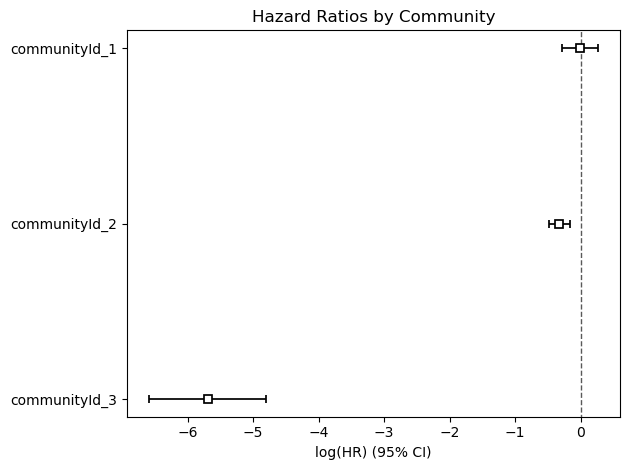

In [3371]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['FFS_STATUS_EVENT'] = mod_df['FFS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['FFS_MONTHS'], group['FFS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['FFS_MONTHS'], group_b['FFS_MONTHS'],
                          event_observed_A=group_a['FFS_STATUS_EVENT'],
                          event_observed_B=group_b['FFS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='FFS_MONTHS', event_col='FFS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

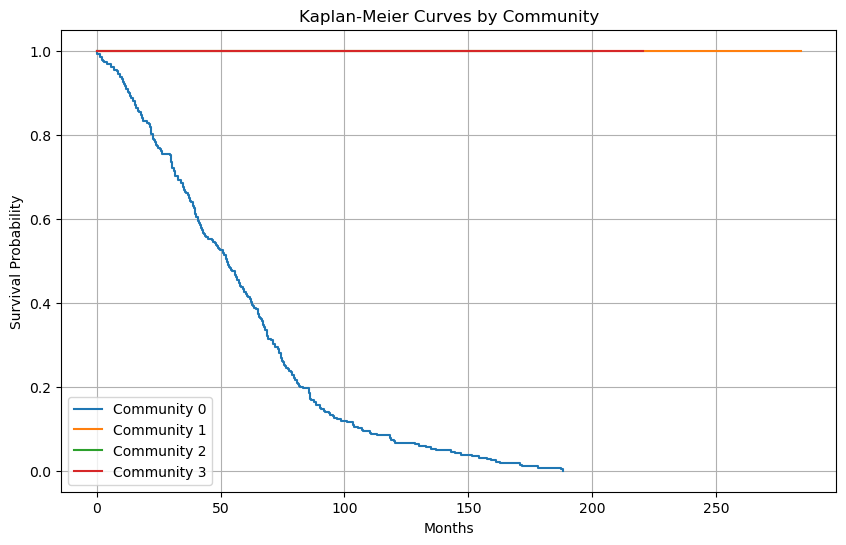

Log-Rank Test between Community 0 and 1: p = 2.4589868296521868e-45
Log-Rank Test between Community 0 and 2: p = 4.989543021903071e-125
Log-Rank Test between Community 0 and 3: p = 1.495987738359456e-136
Log-Rank Test between Community 1 and 2: p = 1.0
Log-Rank Test between Community 1 and 3: p = 1.0
Log-Rank Test between Community 2 and 3: p = 1.0


<lifelines.CoxPHFitter: fitted with 1062 total observations, 776 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 286
   partial log-likelihood = -1335.36
         time fit was run = 2025-07-25 12:12:56 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1 -21.54      0.00   3082.27        -6062.69         6019.60                0.00                 inf
communityId_2 -21.39      0.00   1816.20        -3581.08         3538.30                0.00                 inf
communityId_3 -21.40      0.00   1737.25        -3426.34         3383.55                0.00                 inf

               cmp to     z    p  -log2(p)
covariate                                 
communityId_1    0.00 -0.01 0.99      0.01
communityId_2    0.00 -0.01 0.99      0.01
communityId_3    0.00 -0.01 0.99      0.01
---
Concordance = 0.90
Partial AIC = 2676.72
log-likelihood ratio test = 1014.28 on 3 df
-log2(p) of ll-ratio test = 726.98

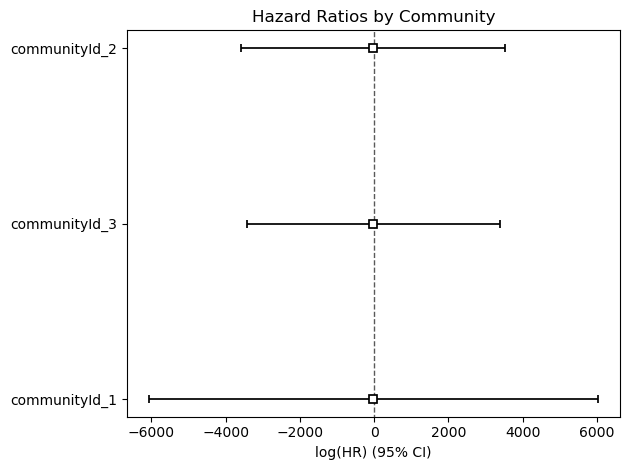

In [3372]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['OS_STATUS_EVENT'] = mod_df['OS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['OS_MONTHS'], group['OS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['OS_MONTHS'], group_b['OS_MONTHS'],
                          event_observed_A=group_a['OS_STATUS_EVENT'],
                          event_observed_B=group_b['OS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='OS_MONTHS', event_col='OS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

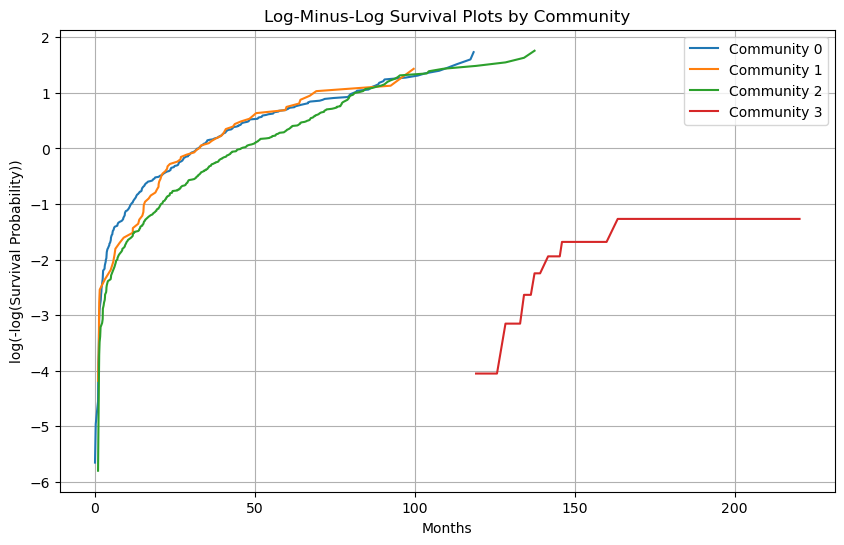

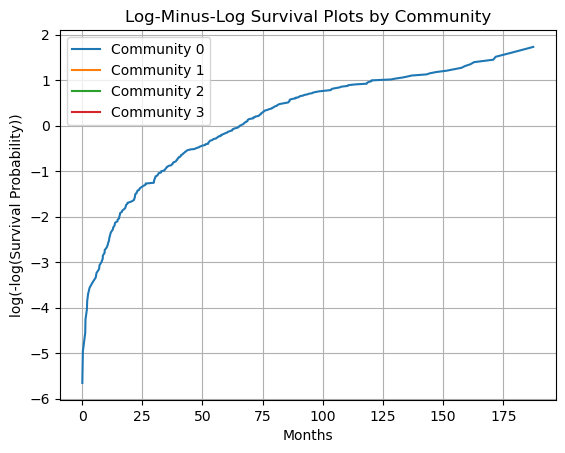

In [3373]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Log-minus-log plots
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for label in ['FFS', 'OS']:
    for name, group in mod_df.groupby('communityId'):
        kmf.fit(group[f'{label}_MONTHS'], group[f'{label}_STATUS_EVENT'], label=f"Community {name}")
        survival_prob = kmf.survival_function_[f"Community {name}"]
        log_minus_log = np.log(-np.log(survival_prob))
        plt.plot(survival_prob.index, log_minus_log, label=f"Community {name}")

    plt.title("Log-Minus-Log Survival Plots by Community")
    plt.xlabel("Months")
    plt.ylabel("log(-log(Survival Probability))")
    plt.legend()
    plt.grid(True)
    plt.show()


## Visualisation

In [3374]:
base_path = "../../figures/chapter4/"
os.makedirs(base_path, exist_ok=True)

In [3375]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
from collections import Counter

def plot_violin_numeric(df, feature, comm1, comm2, ax, show_median=True, color_palette='Set2'):
    data = df[df['communityId'].isin([comm1, comm2])]
    sns.violinplot(data=data, x='communityId', y=feature, ax=ax, palette=color_palette, inner='box')
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Community ID")
    ax.set_ylabel(feature)
    # Annotate median
    for i, cid in enumerate([comm1, comm2]):
        median = data[data['communityId'] == cid][feature].median()
        # ax.axhline(median, color=sns.color_palette(color_palette)[i], linestyle='--', linewidth=1)
        ax.text(i, median, f"Median: {median:.2f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')

def plot_box_numeric(df, feature, comm1, comm2, ax, show_median=True, color_palette='Set2'):
    data = df[df['communityId'].isin([comm1, comm2])]
    sns.boxplot(data=data, x='communityId', y=feature, ax=ax, palette=color_palette)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Community ID")
    ax.set_ylabel(feature)
    # Annotate median
    for i, cid in enumerate([comm1, comm2]):
        median = data[data['communityId'] == cid][feature].median()
        ax.text(i, median, f"Median: {median:.2f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')

In [3376]:
def round_percentages_to_100(row):
    """Given a list/array of values, return a list of rounded percentages (1 decimal) summing to 100."""
    total = np.sum(row)
    if total == 0:
        return [0.0] * len(row)
    raw = [v / total * 100 for v in row]
    rounded = [np.floor(x * 10) / 10 for x in raw]
    diff = round(100 - sum(rounded), 1)
    # Distribute the remaining difference to the largest remainders
    remainders = [x - np.floor(x * 10) / 10 for x in raw]
    idxs = np.argsort(remainders)[::-1]
    i = 0
    while abs(diff) > 1e-6:
        rounded[idxs[i % len(rounded)]] += 0.1
        diff = round(100 - sum(rounded), 1)
        i += 1
    return [round(x, 1) for x in rounded]

In [3377]:
cll_epitype_colors = {
    'm-CLL': '#66c2a5',
    'i-CLL': '#8da0cb', 
    'n-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

tumor_colors = {
    'M-CLL': '#66c2a5',
    'U-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

ighv_colors = {
    'mutated': '#66c2a5',
    'unmutated': '#fc8d62',
    'unknown': '#7f7f7f',
}


legend_mapping = {
    'CLL_EPITYPE': cll_epitype_colors,
    'TUMOR_MOLECULAR_SUBTYPE': tumor_colors,
    'IGHV_MUTATION_STATUS': ighv_colors
}

def plot_stacked_bar_categorical(
    df, feature, comm1, comm2, ax,
    y_axis='count', annotation='percent',
):
    """
    y_axis: 'count' or 'percent' (controls y-axis)
    annotation: 'count' or 'percent' (controls annotation on bars)
    category_map: dict {category_value: color_hex, ...} for legend order and color
    """
    data = df[df['communityId'].isin([comm1, comm2])]
    ct = pd.crosstab(data['communityId'], data[feature])

    # Order columns and set colors if map provided
    category_map = legend_mapping.get(feature, None)
    if category_map:
        ordered_cats = list(category_map.keys())
        ct = ct.reindex(columns=ordered_cats, fill_value=0)
        colors = [category_map[k] for k in ordered_cats]
    else:
        colors = None

    # Compute percent table for annotation if needed
    ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

    # Choose y-axis
    if y_axis == 'percent':
        plot_df = ct_percent
        ylabel = "Percentage"
    else:
        plot_df = ct
        ylabel = "Count"

    # Plot
    plot_df.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel("Community ID")
    ax.set_ylabel(ylabel)
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    if category_map:
        # Order legend as in map
        ax.legend(handles, ordered_cats, bbox_to_anchor=(1.05, 1), loc='upper left')
        # title=feature, 
    else:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # title=feature, 

     # Annotate (robust: loop over bars and categories)
    bar_categories = list(plot_df.columns)
    bar_positions = np.arange(len(plot_df.index))  # x positions for bars (communities)
    for bar_idx, comm in enumerate(plot_df.index):
        y_bottom = 0
        # For percent annotation, get rounded percentages that sum to 100
        if annotation == 'percent':
            row_counts = ct.iloc[bar_idx].values
            rounded_percents = round_percentages_to_100(row_counts)
        for cat_idx, cat in enumerate(bar_categories):
            value = plot_df.iloc[bar_idx][cat]
            if value == 0:
                continue
            count = ct.iloc[bar_idx][cat] if cat in ct.columns else 0
            percent = ct_percent.iloc[bar_idx][cat] if cat in ct_percent.columns else 0
            if annotation == 'percent':
                text = f"{rounded_percents[cat_idx]}%"
            else:
                text = f"{int(count)}"
            y = y_bottom + value / 2
            ax.annotate(
                text,
                (bar_positions[bar_idx], y),
                ha='center', va='center', fontsize=8, color='black'
            )
            y_bottom += value
            

In [3378]:
community_names = {
    0: "Early Failure with Death",
    1: "Early Failure with Survival",
    2: "Intermediate Failure with Survival",
    3: "Sustained Survival"
}

In [3379]:
def compare_communities(
    df, comm1, comm2, 
    numeric_features=None, 
    categorical_features=None, 
    y_axis_categorical='count',
    annotation_categorical='percent',
    violin_palette='Set2',
    figsize=(12, 8)
):
    # Count number of plots
    n_numeric = len(numeric_features) if numeric_features else 0
    n_categorical = len(categorical_features) if categorical_features else 0
    n_plots = n_numeric + n_categorical
    ncols = int(np.ceil(np.sqrt(n_plots)))
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if n_plots > 1 else [axes]
    idx = 0

    # Numeric features
    if numeric_features:
        for feature in numeric_features:
            if feature == 'MUTATION_COUNT':
                plot_box_numeric(df, feature, comm1, comm2, axes[idx], color_palette=violin_palette)
            else:
                plot_violin_numeric(df, feature, comm1, comm2, axes[idx], color_palette=violin_palette)
            idx += 1

    # Categorical features
    if categorical_features:
        for feature in categorical_features:
            plot_stacked_bar_categorical(df, feature, comm1, comm2, axes[idx], y_axis_categorical, annotation_categorical)
            idx += 1

    # Hide unused axes
    for j in range(idx, len(axes)):
        axes[j].axis('off')

    # title for the entire figure
    fig.suptitle(f"Comparison between \"{community_names[comm1]}\" (CommID {comm1}) and \"{community_names[comm2]}\" (CommID {comm2})", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    fig.savefig(f"{base_path}community_comparison_{comm1}_{comm2}.png", dpi=300, bbox_inches='tight')
    plt.show()

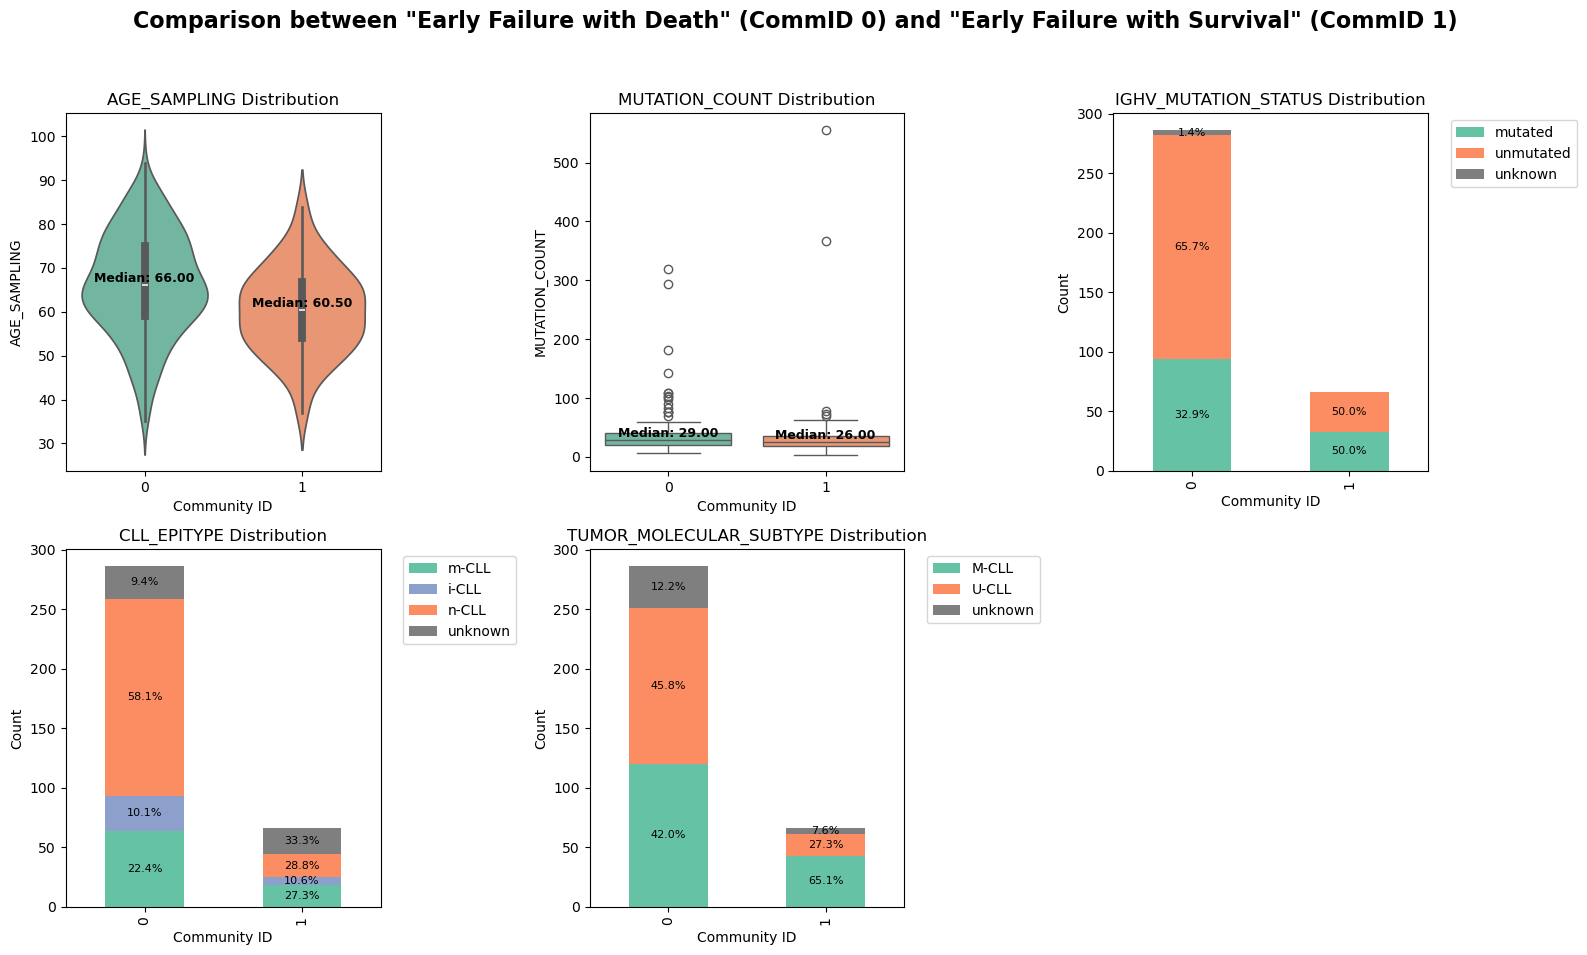

In [3380]:
numeric_features = ['AGE_SAMPLING', 'MUTATION_COUNT']
categorical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']

compare_communities(
    merged_df, 
    comm1=0, comm2=1,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    figsize=(16, 10),
)

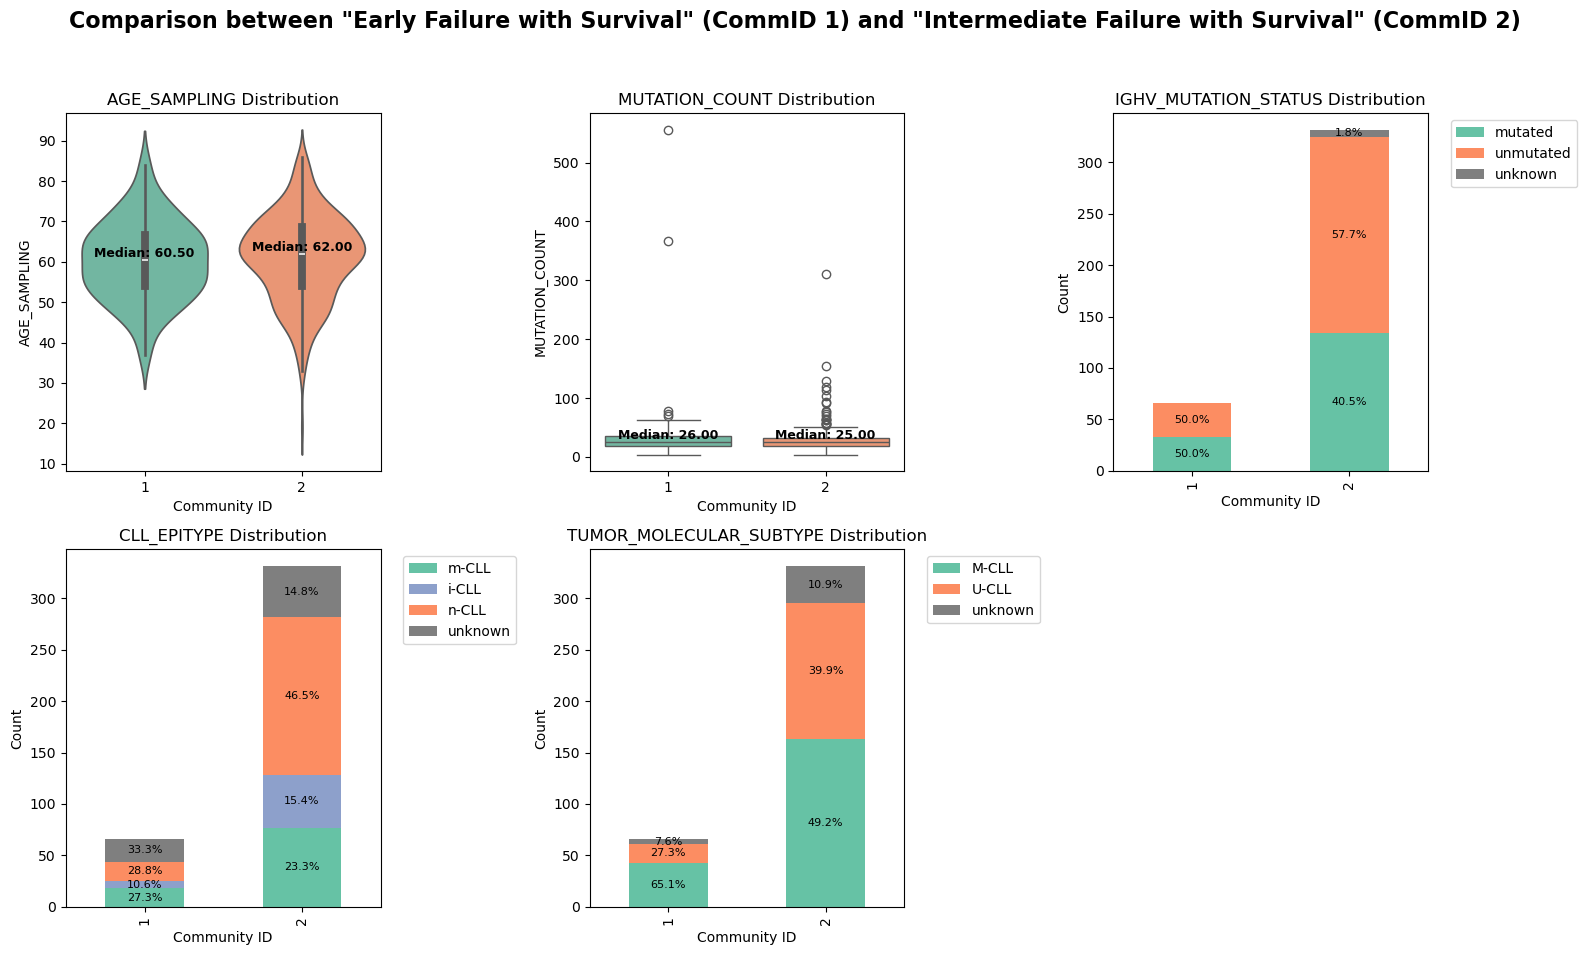

In [3381]:
compare_communities(
    merged_df, 
    comm1=1, comm2=2,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    figsize=(16, 10)
)

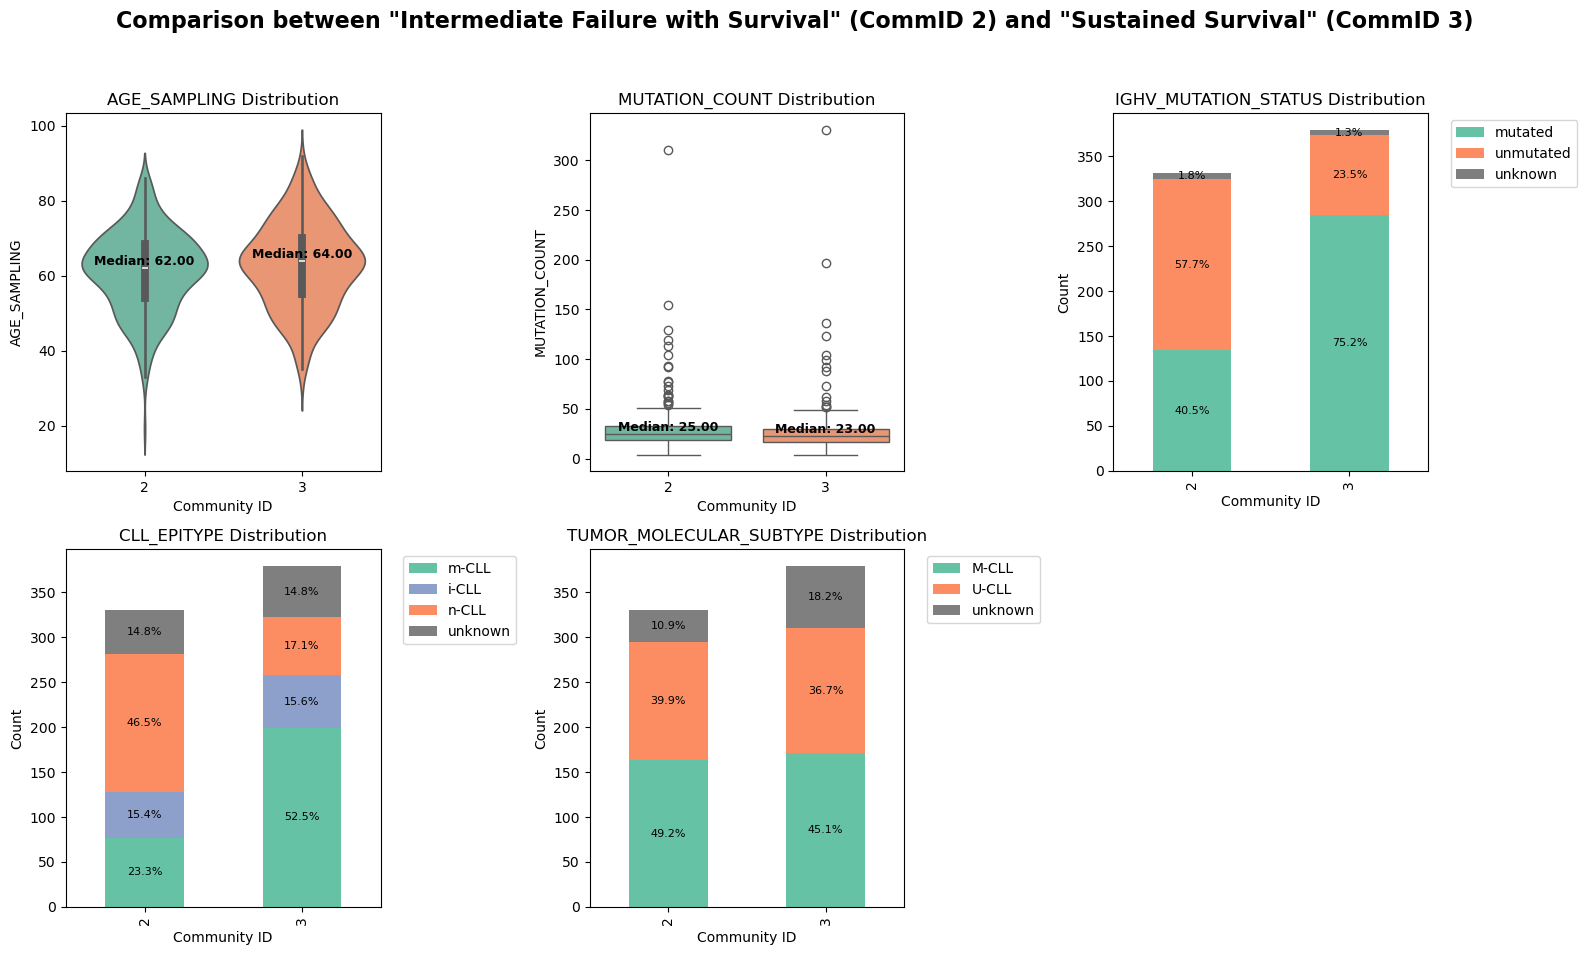

In [3382]:
compare_communities(
    merged_df, 
    comm1=2, comm2=3,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    figsize=(16, 10)
)

In [3383]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd

def plot_venn_feature_figure(
    top_dict, comm1, comm2, label, 
    min_pct=0, 
    top_selected=10,
    left_name=None, right_name=None, 
    save_prefix="venn"
):
    """
    Creates and saves a solo Venn diagram for a feature (e.g., mutations or treatments).
    - top_dict: {communityId: [{label: value, 'Percentage': pct}, ...]}
    - comm1, comm2: community ids (left, right)
    - label: key in dict (e.g., 'hugoGeneSymbol' or 'TREATMENT_AFTER_SAMPLING')
    - min_pct: minimum percentage to include
    - left_name, right_name: custom names for communities (optional)
    - save_prefix: prefix for filename
    """
    # Filter out NaN labels
    set1 = {d[label]: d['Percentage'] for d in top_dict.get(comm1, []) if d['Percentage'] >= min_pct and not pd.isna(d[label])}
    set2 = {d[label]: d['Percentage'] for d in top_dict.get(comm2, []) if d['Percentage'] >= min_pct and not pd.isna(d[label])}
    print(set1, set2)
    
    keys1, keys2 = set(set1.keys()), set(set2.keys())

    fig, ax = plt.subplots(figsize=(10, 8))
    venn = venn2([keys1, keys2], set_labels=(
        left_name or f"Community {comm1}", 
        right_name or f"Community {comm2}"
    ), ax=ax)
    from matplotlib_venn import venn2_circles
    venn2_circles(subsets=(keys1, keys2), ax=ax)

    # Annotate unique and common, skip NaN
    for keys, venn_id in zip([keys1-keys2, keys2-keys1, keys1&keys2], ['10', '01', '11']):
        # Remove NaN keys
        keys = [k for k in keys if not pd.isna(k)]
        # Sort by string representation to avoid type errors
        # keys_sorted = sorted(keys, key=lambda x: str(x))
        if venn_id == '10':
            # Sort by set1 percentage descending
            keys_sorted = sorted(keys, key=lambda k: -set1[k])
        elif venn_id == '01':
            # Sort by set2 percentage descending
            keys_sorted = sorted(keys, key=lambda k: -set2[k])
        else:
            # Sort by average percentage descending
            keys_sorted = sorted(keys, key=lambda k: -((set1.get(k, 0) + set2.get(k, 0))/2))
    
        if venn.get_label_by_id(venn_id):
            if venn_id == '10':
                text = "\n".join([f"{k}\n({set1[k]:.1f}%)" for k in keys_sorted])
            elif venn_id == '01':
                text = "\n".join([f"{k}\n({set2[k]:.1f}%)" for k in keys_sorted])
            else:
                text = "\n".join([
                    f"{k}\n({set1[k]:.1f}% vs {set2[k]:.1f}%)"
                    for k in keys_sorted
                ])
            venn.get_label_by_id(venn_id).set_text(text if text else "")
    if label == 'hugoGeneSymbol':
        ax.set_title(f"Venn Diagram: Mutations (hugoGeneSymbol) (Top {top_selected}, % of patients)", fontsize=16)
    else:
        ax.set_title(f"Venn Diagram: Treatment After Sampling (% of patients)", fontsize=16)
    plt.tight_layout()
    fname = f"{base_path}{save_prefix}_{label}_comm{comm1}_comm{comm2}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved Venn diagram to {fname}")

{'SF3B1': np.float64(24.61), 'TP53': np.float64(15.62), 'ATM': np.float64(13.67), 'NOTCH1': np.float64(8.98), 'TTN': np.float64(8.98), 'XPO1': np.float64(8.98), 'PCLO': np.float64(8.2), 'BRAF': np.float64(6.25), 'POT1': np.float64(5.86), 'EGR2': np.float64(5.86)} {'SF3B1': np.float64(22.22), 'TTN': np.float64(9.52), 'ZMYM3': np.float64(7.94), 'CSMD3': np.float64(7.94), 'CSMD1': np.float64(7.94), 'USH2A': np.float64(7.94), 'FAT1': np.float64(7.94), 'AHNAK': np.float64(7.94), 'KRAS': np.float64(7.94), 'MYD88': np.float64(7.94)}


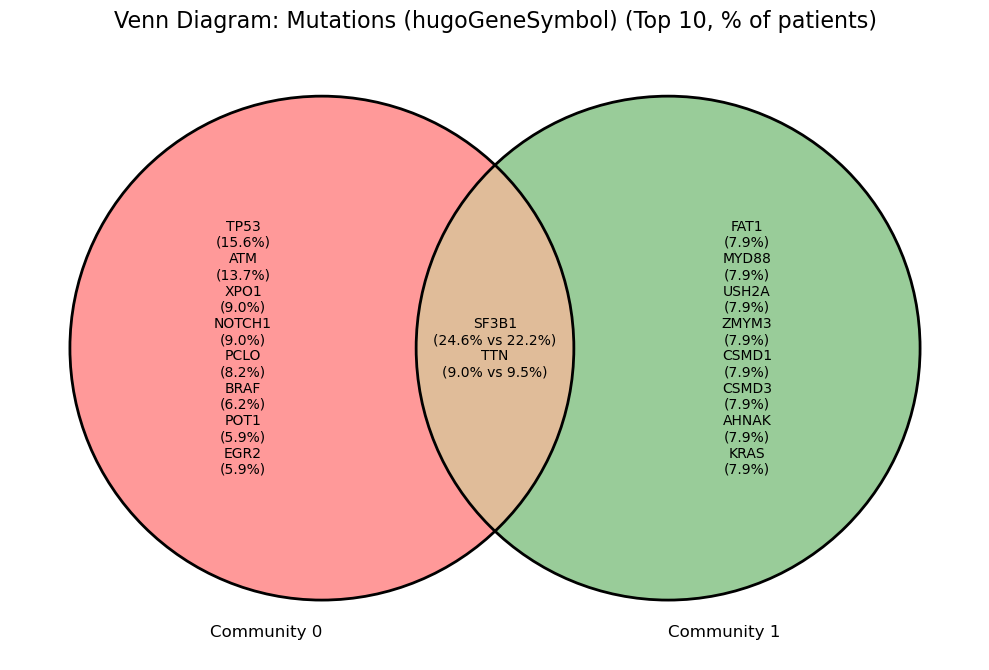

Saved Venn diagram to ../../figures/chapter4/venn_mutations_hugoGeneSymbol_comm0_comm1.png


In [3384]:
plot_venn_feature_figure(top_mutations, 0, 1, 'hugoGeneSymbol', min_pct=0, save_prefix="venn_mutations")

{'Chemo + Ab': 32.02, 'Chemo + no Ab': 11.78, 'BTK inhibitor': 3.93, 'Ab + no chemo': 2.42, 'PI3K + chemo + Ab': 1.21, 'LEN + chemo + Ab': 0.91, 'LEN + Ab': 0.91, 'BTK + chemo + Ab': 0.6, 'BTK inhibitor + Ab': 0.6, 'BCL2 + chemo': 0.3, 'PI3K + Ab': 0.3, 'CART + I': 0.3, 'BCL2 inhibitor': 0.3, 'BCL2 + Ab': 0.3, 'BCL2 + BTK': 0.3} {'Chemo + Ab': 10.29, 'Chemo + no Ab': 3.17, 'BTK inhibitor': 1.06, 'Ab + no chemo': 1.06, 'BCL2 + chemo': 0.53, 'LEN + chemo + Ab': 0.26, 'SYK inhibitor': 0.26, 'LEN + Ab': 0.26}


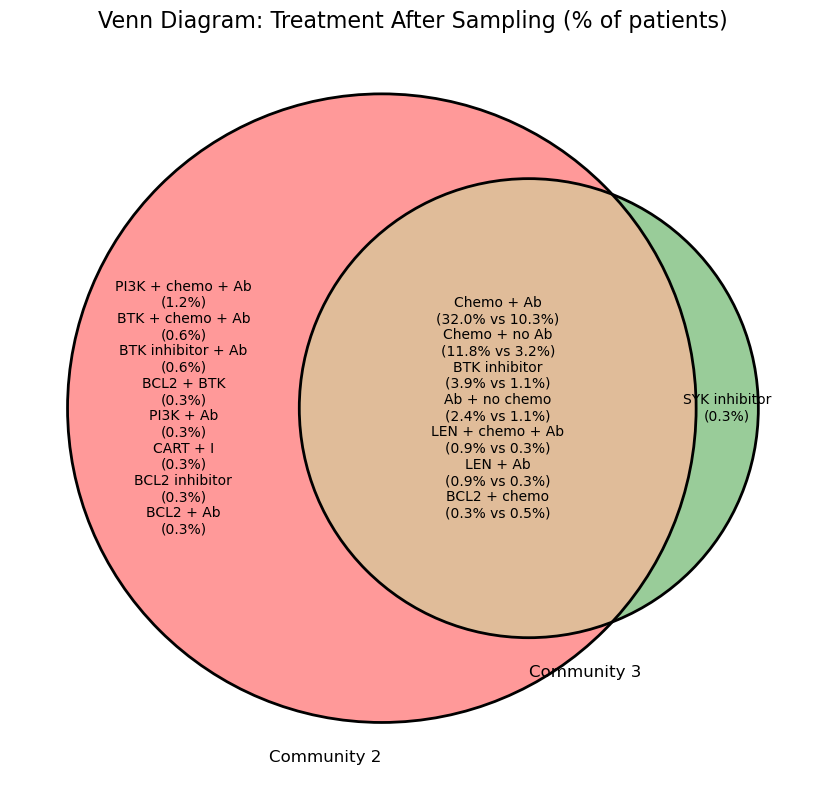

Saved Venn diagram to ../../figures/chapter4/venn_treatment_TREATMENT_AFTER_SAMPLING_comm2_comm3.png


In [3385]:
plot_venn_feature_figure(treatment_data, 2, 3, 'TREATMENT_AFTER_SAMPLING', min_pct=0, save_prefix="venn_treatment")